# Observation of the melting ice: facade of the Eqi glacier

We used Landsat dataset for the study

In [1]:
# Planetary Computer, STAC
import pystac
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Stats and vector data
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

# Image processing
import rasterio as rio
import rasterio.plot, rasterio.features, rasterio.mask, rasterio.fill  # Not loaded by default
import skimage.morphology, skimage.measure

# Plotting
import matplotlib.pyplot as plt
import IPython.display
import ipywidgets
import leafmap

# For nice HTML outputs
import rich.table

## Environment

In [2]:
plt.style.use('default')
folium_tile = "CartoDB Positron"

## Import images from landsat

We search on Planetary Computer Explorer

### 1985 image

In [3]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LT05_L2SP_011011_19850903_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
before = planetary_computer.sign(item)

In [4]:
before.assets["rendered_preview"].href


'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LT05_L2SP_011011_19850903_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55'

In [5]:
before;

### 2022 image

In [6]:
# FOR 2022
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC08_L2SP_010011_20220801_02_T1"
#item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC09_L2SP_011011_20220715_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
after = planetary_computer.sign(item)

In [7]:
after.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LC08_L2SP_010011_20220801_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55'

In [8]:
after;

## Explore a dataset

In [9]:
# Rich provides an easy way to build pretty HTML tables
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in before.assets.items():
    table.add_row(asset_key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Description                                                      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ qa               │ Surface Temperature Quality Assessment Band                      │
│ ang              │ Angle Coefficients File                                          │
│ red              │ Red Band                                                         │
│ blue             │ Blue Band                                                        │
│ drad             │ Downwelled Radiance Band                                         │
│ emis             │ Emissivity Band                                                  │
│ emsd             │ Emissivity Standard Deviation Band                               │
│ lwir             │ Surface Temperature Band                                         │
│ trad             │ Thermal Radiance Band                                            │
│ urad             │ Upwelled Radiance Band                                           │
│ atran            │ Atmospheric Transmittance Band                                   │
│ cdist            │ Cloud Distance Band                                              │
│ green            │ Green Band                                                       │
│ nir08            │ Near Infrared Band 0.8                                           │
│ swir16           │ Short-wave Infrared Band 1.6                                     │
│ swir22           │ Short-wave Infrared Band 2.2                                     │
│ mtl.txt          │ Product Metadata File (txt)                                      │
│ mtl.xml          │ Product Metadata File (xml)                                      │
│ cloud_qa         │ Cloud Quality Assessment Band                                    │
│ mtl.json         │ Product Metadata File (json)                                     │
│ qa_pixel         │ Pixel Quality Assessment Band                                    │
│ qa_radsat        │ Radiometric Saturation and Dropped Pixel Quality Assessment Band │
│ atmos_opacity    │ Atmospheric Opacity Band                                         │
│ tilejson         │ TileJSON with default rendering                                  │
│ rendered_preview │ Rendered preview                                                 │
└──────────────────┴──────────────────────────────────────────────────────────────────┘

In [10]:
# Use Leafmap to load a STAC layer
m = leafmap.Map()
m.add_stac_layer(
    collection="landsat-c2-l2",
    name=after.datetime.strftime('%Y.%m.%d'),
    item=after.id, 
    assets=["nir08"])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [11]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=before.assets["rendered_preview"].href, width=800)

In [12]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=after.assets["rendered_preview"].href, width=800)

## Rasterio

In [13]:
# Open a remote 8bit GeoTIFF dataset to fetch image geometry
with rio.open(before.assets["red"].href) as ds:
    profile_before = ds.profile

In [14]:
with rio.open(after.assets["red"].href) as ds:
    profile_after = ds.profile

In [15]:
# We can use the same profile dict for different bands since this 3 things are constant
rich.print(profile_before)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 8691,
    'height': 8271,
    'count': 1,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(30.0, 0.0, 310185.0,
       0.0, -30.0, 7847715.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [16]:
# We can use the same profile dict for different bands since this 3 things are constant
rich.print(profile_after)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 8601,
    'height': 8641,
    'count': 1,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(30.0, 0.0, 374985.0,
       0.0, -30.0, 7851015.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

As we can see from the "height", "width" and "transform" values, the images do not have the same size nor the same coordinates

In [17]:
# Let's keep a reference to the CRS
crs = profile_after['crs']
crs

CRS.from_epsg(32622)

The middle of Eqi is located at 528_980 and 7_743_000

In [18]:
# Map size
size = 1000

In [19]:
# facade of the glacier coords
horizontal_coord = 528_980
vertical_coord = 7_743_000

In [20]:
# Horizontal coord is 528_980
left_coord = horizontal_coord - (size/2) * 10
right_coord = horizontal_coord + (size/2) * 10

In [21]:
# Top coordinates is 7_847_715
top_coord = 7_743_000 + (size/2) * 10
bottom_coord = 7_743_000 - (size/2) * 10

We multiplied by 10 because each pixel is 10m

In [22]:
warped_aoi_bounds = (left_coord,
                     bottom_coord,
                     right_coord,
                     top_coord
                    )
warped_aoi_bounds

(523980.0, 7738000.0, 533980.0, 7748000.0)

### Define windows

We do a different one since the image size and location aren't the same

#### before window

In [23]:
# Round pixel size and offsets: we can't slice any array using floating points
aoi_window_before = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile_before["transform"])
aoi_window_before = aoi_window_before.round_shape().round_offsets()
aoi_window_before

Window(col_off=7126, row_off=3323, width=333, height=333)

#### after window

In [24]:
aoi_window_after = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile_after["transform"])
aoi_window_after = aoi_window_after.round_shape().round_offsets()
aoi_window_after

Window(col_off=4966, row_off=3433, width=333, height=333)

## Numpy array manipulations and plotting

In [25]:
# Load 16bit data as numpy array, using rasterio to open remote COG file
def rio_stack(
    item: pystac.Item,
    band_list: list,
    window: rio.windows.Window = None
):
    """Load and stack different bands in a STAC item, return stacked array and geometry profile"""
    array_list = []
    # Collect arrays
    for band_id in band_list:
        url = item.assets[band_id].href
        with rasterio.open(url) as ds:
            profile = ds.profile
            data = ds.read(1, window=window)  # read(1) returns 2D array
            array_list.append(data)
    # Update metadata dict
    profile["count"] = len(array_list)
    if window is not None:
        # Update image geometry
        profile["transform"] = rio.windows.transform(window, profile["transform"])
        # ! Width and height are integer since we used aoi_window.round_shape() !
        profile["width"], profile["height"] = window.width, window.height

    # N.B. this function is valid if only if all bands have the same geometry
    return np.stack(array_list), profile

In [26]:
# Here we also reorder BGR bands to RGB
array_before, profile = rio_stack(before, ["red", "green", "blue", "nir08", "swir22"], aoi_window_before)
array_after, _ = rio_stack(after, ["red", "green", "blue", "nir08", "swir22"], aoi_window_after)

# Make sure to check the profile dict
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 333,
    'height': 333,
    'count': 5,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(30.0, 0.0, 523965.0,
       0.0, -30.0, 7748025.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [27]:
array_before.max(), array_after.max()

(65535, 54557)

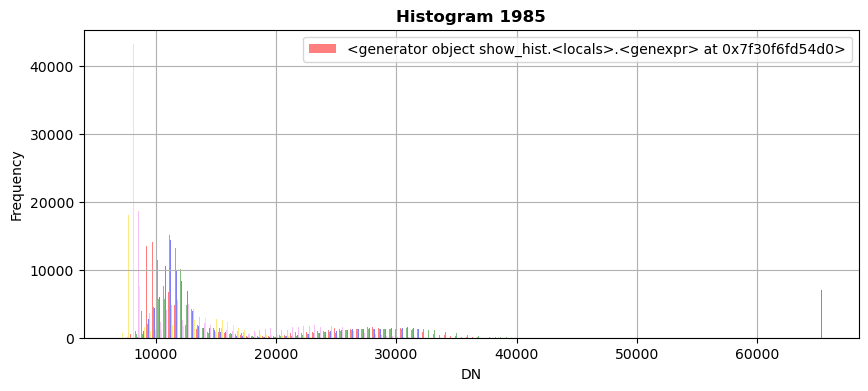

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_before, bins=128, stacked=False, alpha=0.5, title="Histogram 1985")

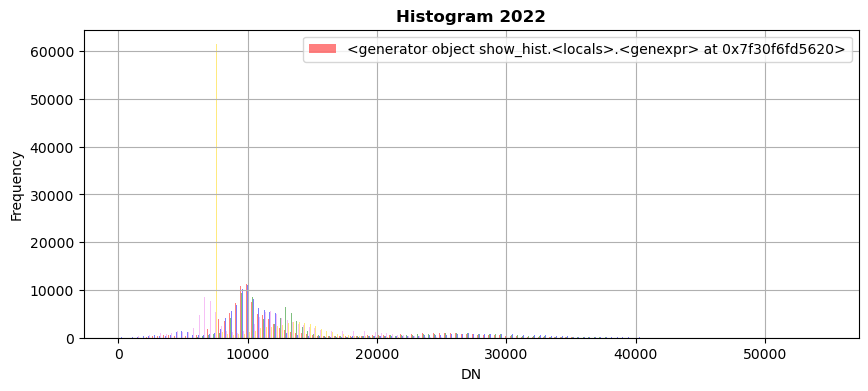

In [29]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_after, bins=128, stacked=False, alpha=0.5, title="Histogram 2022")

In [30]:
# # Write raster data (always make sure your profile dict is correct)
# img_path = before.id + "_RGB_NIR.tif"
# # Open in "write" mode, here you may pass other params for GDAL as kwargs (after **profile)
# with rasterio.open(img_path, "w", **profile) as w:
#     w.write(array_before)

In [31]:
array_reshaped = array_before.reshape([5, -1])  # or array_before.reshape([4, 2095*1260])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

Min:  [7801 8161 8318 7361 6899]
Max:  [52532 55523 65535 43676 29988]
Mean [15928.94579264 17193.38212086 18944.94709124 14431.77512648
 10191.34397461]
Std [ 8072.32179916  8413.10669275 13980.10775466  6124.64648307
  3485.90640182]


In [32]:
# There is no 0, it means there is no pixel without data

In [33]:
array_reshaped = array_after.reshape([5, -1])  # or array_before.reshape([4, 2095*1260])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

Min:  [   0    0    0 1482 7069]
Max:  [49778 52236 54557 34618 25340]
Mean [13135.2375168  14490.28592557 13667.79672465 11204.7889421
  9747.82210138]
Std [6769.22588069 7026.85159387 8057.66994389 4760.1916184  3345.25442736]


In [34]:
# In this array, zero is used as nodata value.

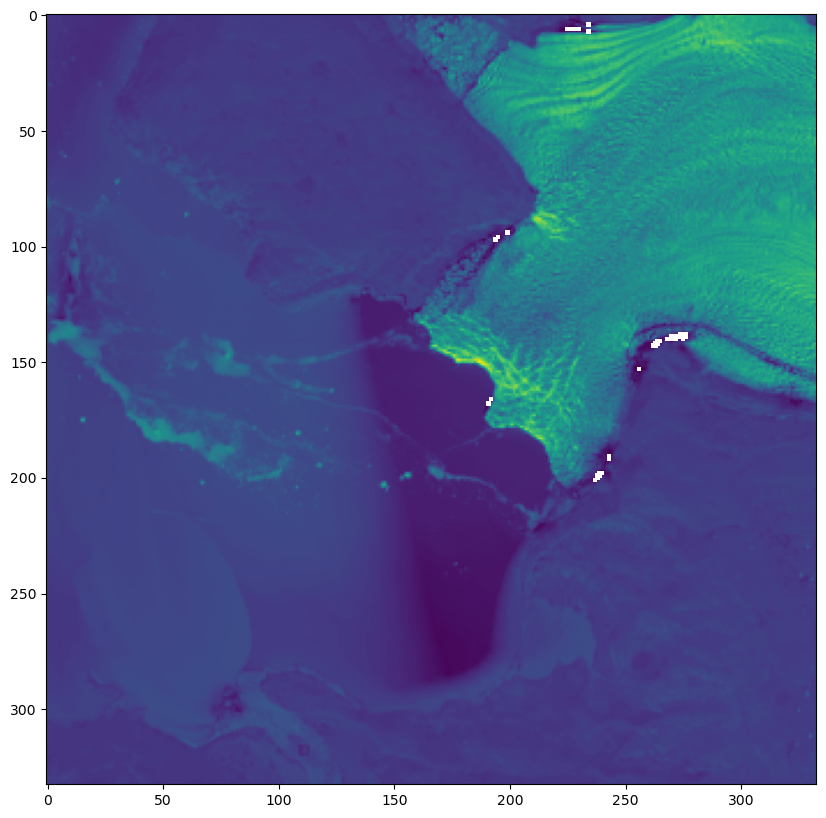

In [35]:
# Let's display NaN values
with rasterio.open(after.assets['blue'].href) as ds:
    profile = ds.profile
    mask = ds.read_masks(window=aoi_window_after)
    data = ds.read(window=aoi_window_after)

# Let's build a numpy masked array. We need to invert it since GDAL and Numpy aren't using the same convention
mask = ~mask.astype(bool)

# Build a mask, we decide to fill missing values with the dataset declared nodata value (e.g. zero)
masked_data = np.ma.masked_array(data, mask, fill_value=profile['nodata'])

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(masked_data[0])

Since there are no lots of NaN values, we won't worry about it

In [36]:
# Use slicing to get first bands (Keep RGB)
array_3b_before, array_3b_after = array_before[:3], array_after[:3]
array_3b_before.shape, array_3b_after.shape

((3, 333, 333), (3, 333, 333))

In [37]:
new_array_before = np.moveaxis(array_3b_before, 0, 2)
new_array_before = np.interp(new_array_before, (1000, 30000), (0, 255))

In [38]:
new_array_after = np.moveaxis(array_3b_after, 0, 2)
new_array_after = np.interp(new_array_after, (1000, 30000), (0, 255))

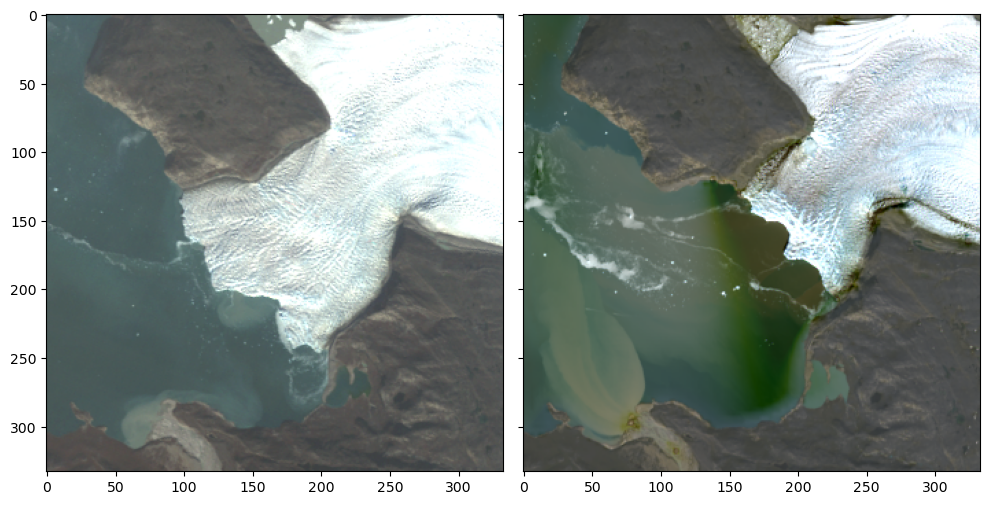

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(new_array_before.astype('uint8'))
axes[1].imshow(new_array_after.astype('uint8'));

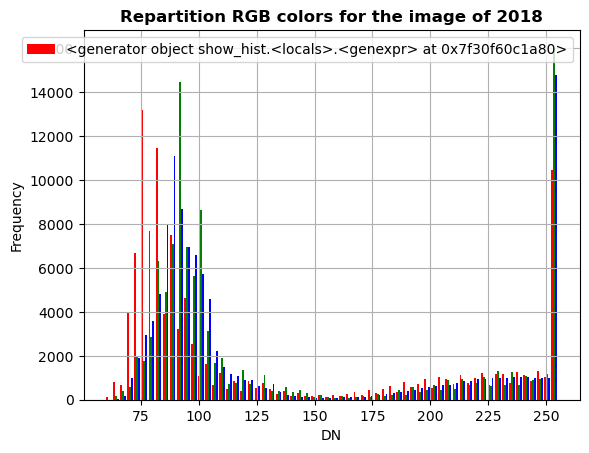

In [40]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_before), bins=64,title="Repartition RGB colors for the image of 2018")

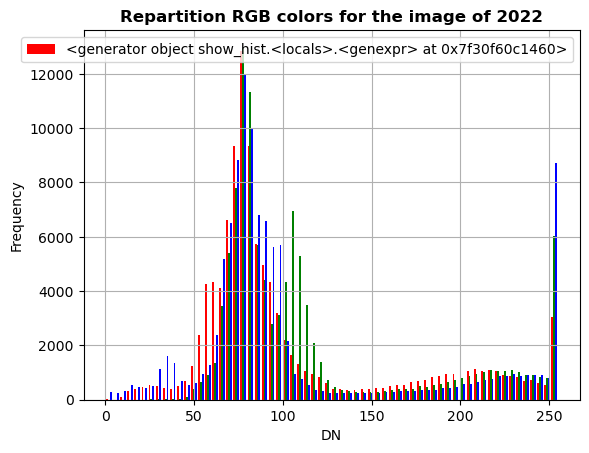

In [41]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_after), bins=64,title="Repartition RGB colors for the image of 2022")

The colors seem correct

### Rebuild the image with RGB bands

Since there is no "visual" bands like for sentinel2, we have to rebuild the visual with rgb colors

In [42]:
# If you ever need to build a rendered (encoded) image object from a numpy array (usable with IPython.display.Image), you can use PIL
import PIL
def pil_image_from_array(array, target_width=None):
    """Build PIL image object from a numpy array, optional image transform to target width"""
    # Another way to change bands order
    array = np.transpose(array, axes=[1, 2, 0])
    img = PIL.Image.fromarray(array)
    if not target_width:
        return img
    w, h = img.size[0], img.size[1]
    aspect = w / h
    target_height = (int)(target_width / aspect)
    return img.resize((target_width, target_height), PIL.Image.Resampling.BILINEAR)

In [43]:
# Need to change the format
new_array_after = new_array_after.astype(np.uint8)

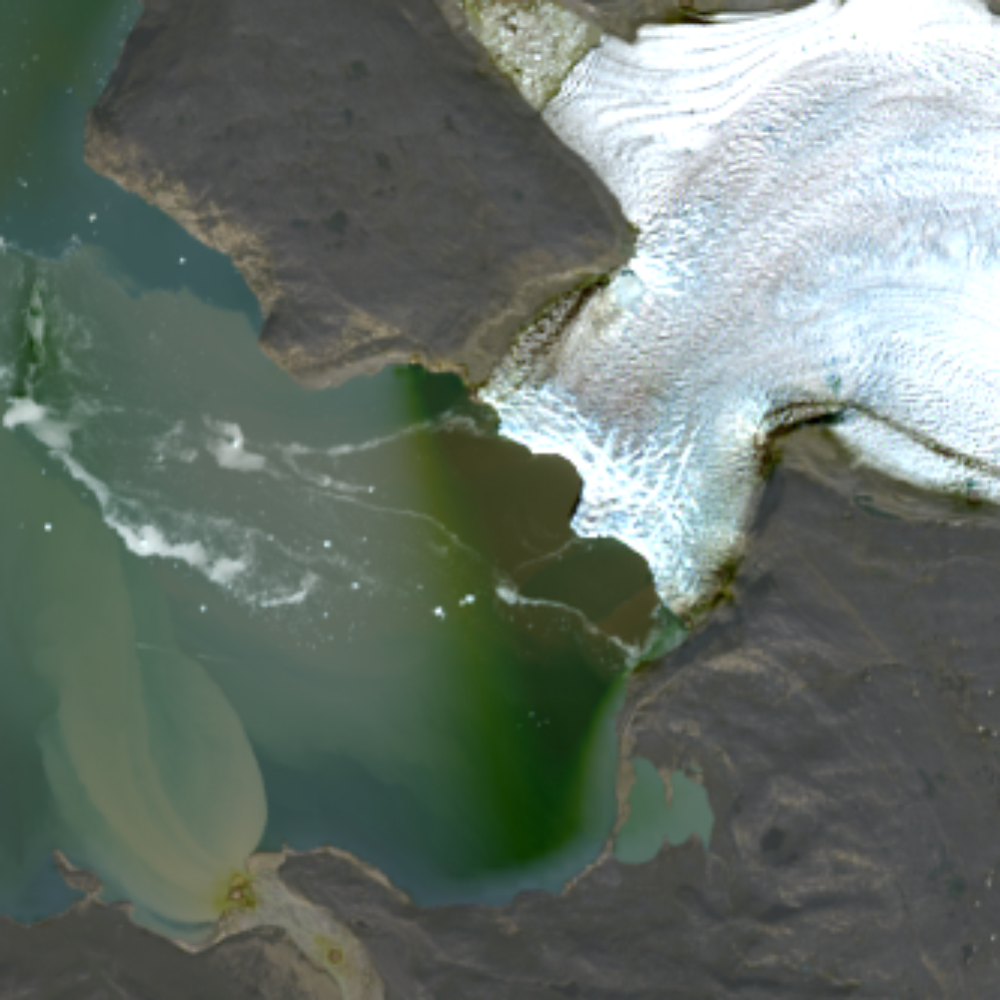

In [44]:
# We need to transpose the array (0, 1, 2) to (2, 0, 1)
pil_image_from_array(
    np.transpose(new_array_after, (2, 0, 1)),
    target_width=1000
)

In [45]:
del new_array_before, new_array_after

## Stack bands

We need to compute bands. 

Since the red, green, blue, nir and swir bands have the same resolution, we don't have to resample

In [46]:
def get_s2_bands(item: pystac.Item, window: rasterio.windows.Window = None):
    array, profile = rio_stack(item, ["red", "blue", "green", "nir08", "swir22"], window)
    return array, profile

In [47]:
get_s2_bands(before, aoi_window_before)[0].shape

(5, 333, 333)

We have 5 bands : Red, Green, Blue, Nir, Swir

## Index & Compute

There are different indexes. The one that is interesting is the NDSI which is the Normalized Difference Snow Index.

https://www.researchgate.net/publication/278750915_Glacier_mapping_and_monitoring_based_on_spectral_data

In [48]:
def compute_ndsi(array: np.ndarray):
    array = array.astype(np.float32)
    green, swir = array[1], array[4]
    return (green - swir) / (green + swir)

In [49]:
array_before, profile = get_s2_bands(before, window=aoi_window_before)
array_after, _ = get_s2_bands(after, window=aoi_window_after)

In [50]:
ndsi_before, ndsi_after = compute_ndsi(array_before), compute_ndsi(array_after)

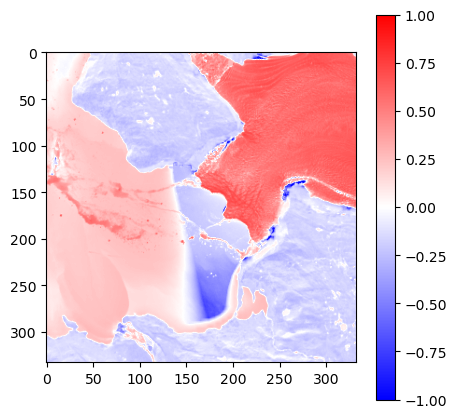

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ndsi_after, vmin=-1, vmax=1, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

In [52]:
# We must to apply a mask to delete the blue part
ndsi_after[ndsi_after < 0.1] = 0.2

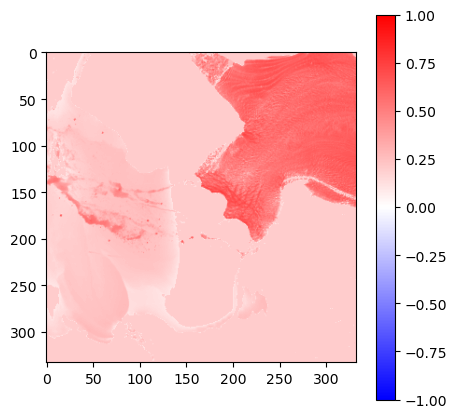

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ndsi_after, vmin=-1, vmax=1, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

As we can see, the blue part was changed. It will helps us to see difference

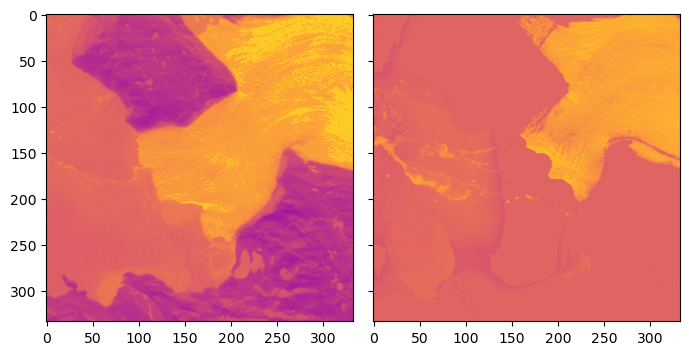

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=True, layout='tight')
axes[0].imshow(ndsi_before, vmin=-1, vmax=1, cmap="plasma", interpolation="bilinear")
axes[1].imshow(ndsi_after, vmin=-1, vmax=1, cmap="plasma", interpolation="bilinear");

In [55]:
dndsi = ndsi_before - ndsi_after

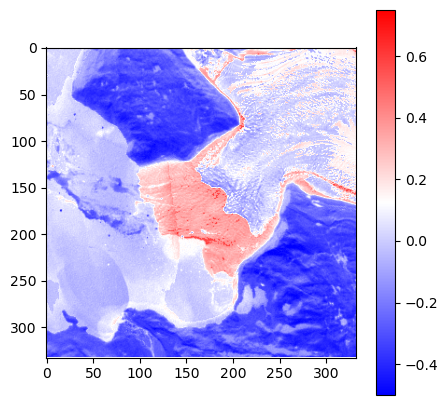

In [56]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dndsi, vmin=-0.5, vmax=0.75, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

The result seems correct

In [57]:
def get_dndsi(before: pystac.Item, after: pystac.Item, window: rasterio.windows.Window = None):
    array_before, profile = get_s2_bands(before, window=aoi_window_before)
    array_after, profile = get_s2_bands(after, window=aoi_window_after)
    ndsi_before, ndsi_after = compute_ndsi(array_before), compute_ndsi(array_after)
    # Apply mask
    ndsi_after[ndsi_after < 0.1] = 0.2
    dndsi = ndsi_before - ndsi_after
    profile.update({"dtype": "float32", "count": 1})
    return dndsi, profile

In [58]:
dndsi, profile = get_dndsi(before, after)

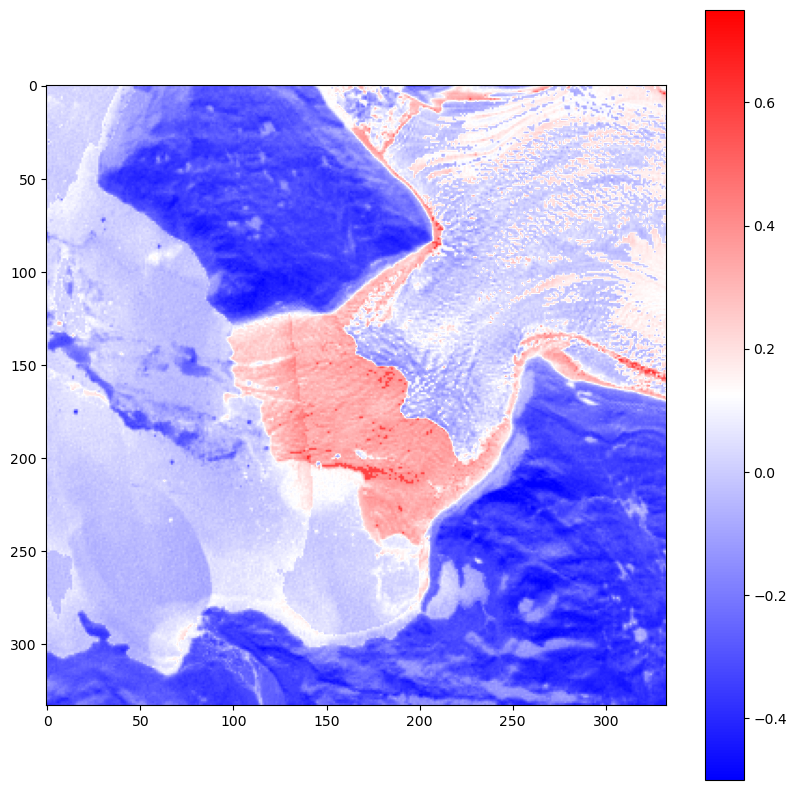

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi, vmin=-0.5, vmax=0.75, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

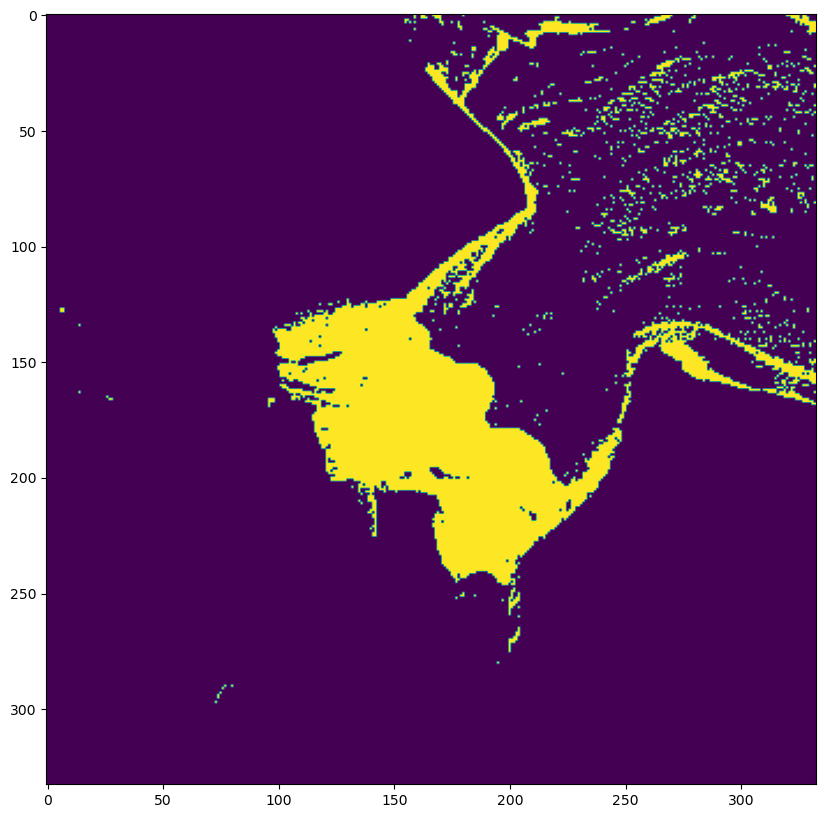

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi > 0.2);

In [61]:
profile.update({"compress": "lzw", "nodata": None})  # Use LZW compression. Unset nodata.
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 333, 'height': 333, 'count': 1, 'crs': CRS.from_epsg(32622), 'transform': Affine(30.0, 0.0, 523965.0,
       0.0, -30.0, 7748025.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [62]:
thresholds = [-0.2, -0.1, 0.18, 0.22, 0.25, 0.3, 0.5]

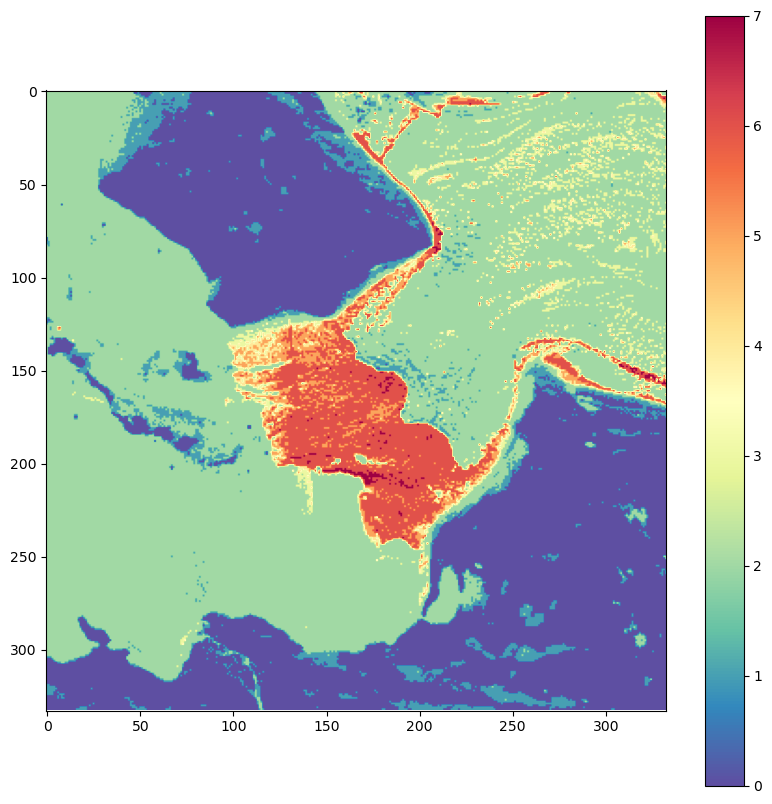

In [63]:
reclassified_dndsi = np.digitize(dndsi, thresholds).astype("uint8")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reclassified_dndsi, cmap='Spectral_r')
fig.colorbar(ax.get_children()[0])

In [64]:
# We will recover the difference in a single group for the GeoDataFrame
# Like that we clean little groups which aren't very huge

In [65]:
thresholds = [-0.2, -0.1, 0.20]

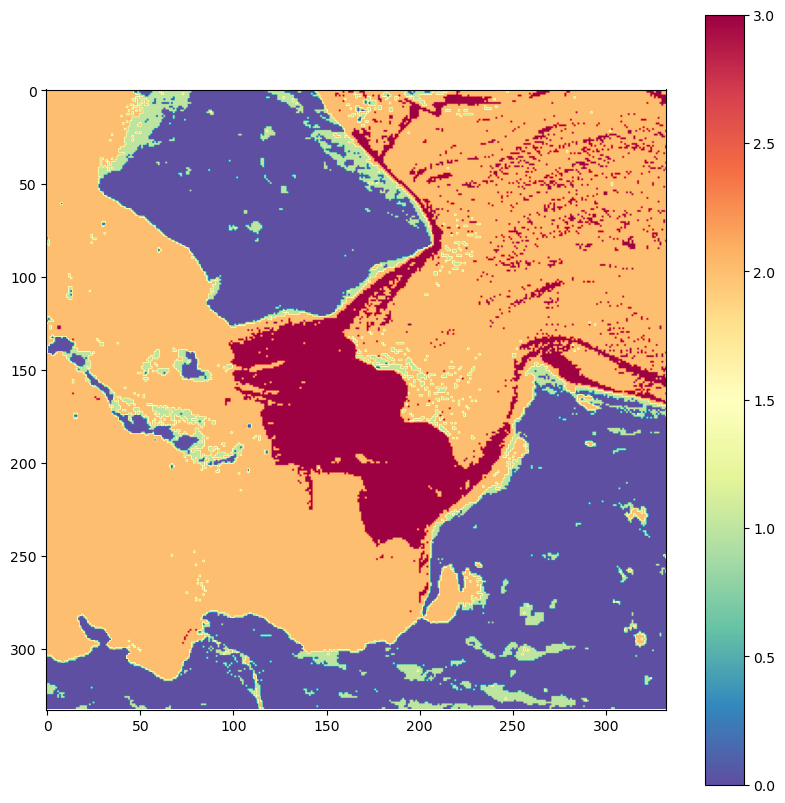

In [66]:
reclassified_dndsi = np.digitize(dndsi, thresholds).astype("uint8")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reclassified_dndsi, cmap='Spectral_r')
fig.colorbar(ax.get_children()[0])

The parts in red/orange are the ones we are most interested in comparing the difference

## Vectorize raster blobs

In [67]:
geoms, values = [], []
# We create a list of shapes using source image transform
for geom, value in rio.features.shapes(
    reclassified_dndsi,
    transform=profile['transform'],
    mask=(reclassified_dndsi >= 2.0),  # also we can mask some values
):
    geoms.append(shapely.geometry.shape(geom))
    values.append(value)

In [68]:
# Create pandas series with our data lists: polygons and pixel values
geoms = gpd.GeoSeries(geoms)
values = pd.Series(values)

In [69]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(values.rename("dNBR_class"), geometry=geoms, crs=crs)
gdf["area_ha"] = gdf.area / 10_000
print("Number of polygons :", len(gdf))

Number of polygons : 1032


In [70]:
# We have a lot of isloated pixels. It's better to remove them or leafmap will take too long to render
gdf.sort_values("area_ha").head()

dNBR_class                                           geometry  area_ha
515         3.0  POLYGON ((530475.000 7745715.000, 530475.000 7...     0.09
615         3.0  POLYGON ((530985.000 7745085.000, 530985.000 7...     0.09
616         3.0  POLYGON ((531045.000 7745055.000, 531045.000 7...     0.09
617         3.0  POLYGON ((530955.000 7745025.000, 530955.000 7...     0.09
618         3.0  POLYGON ((531135.000 7745025.000, 531135.000 7...     0.09

In [71]:
# Remove small areas (Under 2 ha)
gdf = gdf[gdf.area_ha >= 2]
print("Number of polygons :", len(gdf))

Number of polygons : 22


In [72]:
# Explore 
gdf.explore("dNBR_class", tiles=folium_tile, cmap="copper_r", style_kwds={"stroke": None})

In [73]:
gdf = gdf[gdf.dNBR_class > 2]
print("Number of polygons :", len(gdf))

Number of polygons : 12


In [74]:
# Explore 
gdf.explore("dNBR_class", tiles=folium_tile, cmap="copper_r", style_kwds={"stroke": None})

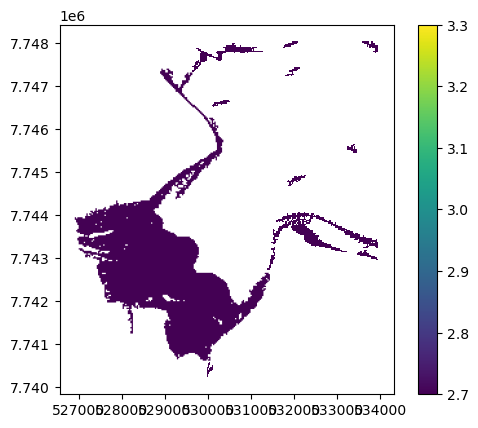

In [75]:
# Plot it (To see it on Github)
fig, ax = plt.subplots(1, 1)
gdf.plot(column='dNBR_class', ax=ax, legend=True);

In [76]:
# We drop the class to keep only the area surface
gdf.drop(['dNBR_class'], axis=1, inplace=True)

We can now add the GeoDataFrame on the map to see which part were present in 1985

## Comparison with initial image

### With before picture

In [77]:
m = leafmap.Map()
m.add_stac_layer(collection="landsat-c2-l2",
                 item=before.id,
                 assets=["nir08"],
                 opacity=0.6
                ),
m.add_gdf(
    gdf,
    fill_colors=["red"],
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### With recent image

In [78]:
m = leafmap.Map()
m.add_stac_layer(collection="landsat-c2-l2",
                 item=after.id,
                 assets=["nir08"],
                 opacity=0.6
                ),
m.add_gdf(
    gdf,
    fill_colors=["red"],
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Conclusion

In [79]:
# surface of melted ice (in ha)
melted_area = gdf["area_ha"].sum()

In [80]:
print("The total area of ice that has melted over the observed area is", round(melted_area, 1), "ha")

The total area of ice that has melted over the observed area is 923.3 ha


In [81]:
football_pitch = 0.714 # in ha
melted_area_in_football_pitch = melted_area / football_pitch

In [82]:
print("The melted surface of ice corresponds to", round(melted_area_in_football_pitch, 1), "football pitch !")

The melted surface of ice corresponds to 1293.2 football pitch !


The values are approximate but overall, we notice that a large amount of ice has melted. 

It is true that it is difficult to really realize the size of the glacier. Just imagine a wall that is over 100m high and over 4km wide!

Also, this study shows only the lost surface. But the glacier has globally lost height. The quantities of melted ice are astronomical and the Eqi glacier represents only a very small part of the North Pole.

Let's take care of our Earth